# Fiducial LSSTCam Zeropoints from Rubin Commissioning

*Author:* Alex Drlica-Wagner, Lynne Jones

This notebook documents the process of modifying the fiducial LSSTCam zeropoint values to agree with data from the later parts of Rubin commissioning (i.e., September 2026 onward). The main finding is that the zeropoints in commissioning are of order 0.1 mag deeper than was anticipated from [SMTN-002](ls.st/SMTN-002). This can likely be attributed to the fact that SMTN-002 used an average mirror reflectivity, which underestimates the throughput close to mirror cleaning. Since the fiducial zeropoint values are used as a real-time metric for survey quality, having systematically negative $\Delta$(ZP) values is considered undesirable.


In [1]:
import os
from collections import OrderedDict as odict
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.time import Time, TimeDelta
import pandas as pd
import scipy.stats
from scipy.stats import binned_statistic

from astropy.stats import sigma_clipped_stats

from lsst.summit.utils import ConsDbClient
from lsst.summit.utils.utils import computeCcdExposureId
os.environ["no_proxy"] += ",.consdb"

# From descolors: https://github.com/DarkEnergySurvey/descolors
BAND_COLORS = odict([
    ('u','#56b4e9'),
    ('g','#008060'),
    ('r','#ff4000'),
    ('i','#850000'),
    ('z','#6600cc'),
    ('y','#000000'),
])

In [2]:
# Fiducial 1-second ZP values from SMTN-002 as stored in obs_lsst
# https://github.com/lsst/obs_lsst/blob/08d5ed9720726fc2ddffac9ce07f000284f70a5e/config/lsstCam/fiducialZeroPoint.py
fiducialZeroPoint = {
    "u": 26.52,
    "g": 28.51,
    "r": 28.36,
    "i": 28.17,
    "z": 27.78,
    "y": 26.82,
}

# Coming from Lynne and opssim
zeropoint_X1 = {
    "u": 26.52229760811932,
    "g": 28.50754554409417,
    "r": 28.360365503331952,
    "i": 28.170373076693625,
    "z": 27.781368851776005,
    "y": 26.813708013594344,
}

ZEROPOINT_OFFSETS_ALEX = {"u": 0.04, "g": 0.08, "r": 0.11, "i": 0.12, "z": 0.12, "y": 0.05}
# Offsets derived by Lynne based on the best 1% of ZPs on good nights
ZEROPOINT_OFFSETS_LYNNE = {"u": 0.12, "g": 0.09, "r": 0.15, "i": 0.14, "z": 0.15, "y": 0.13} # 1%
# Offsets from the opssim predicted ZPs using the 10th, 5th, and 1st percentiles
DELTA_CLOUD = {
    "u": [0.020826795740637394, 0.010756354220722741, -0.005405768530143184],
    "g": [-0.009580355775911185, -0.018427875191516917, -0.03308782923783724],
    "r": [-0.0037376669192035195, -0.014603511624414978, -0.035674294799040496],
    "i": [-0.0025407639490733656, -0.006294812507312564, -0.01600300252274735],
    "z": [0.004238375649181592, -0.001439464627235408, -0.01590226305402304],
    "y": [-0.05777201958055826, -0.08167299877463989, -0.10286637323661381],
}
# Move from 1st percentile offsets to the 
#for band, zp in ZEROPOINT_OFFSETS_LYNNE.items():
#    ZEROPOINT_OFFSETS_LYNNE[band] += (CLOUD[band][2] - CLOUD[band][1])



In [3]:
# Some utility functions for calculating peak positions.
def kde_peak(data, npoints=500, clip=5.0):
    """
    Identify peak using Gaussian kernel density estimator.

    Parameters:
    -----------
    data    : The 1d data sample
    npoints : The number of kde points to evaluate
    clip    : NMAD to clip

    Returns
    -------
    peak : peak of the kde
    """
    return kde(data,npoints,clip)[0]

def kde(data, npoints=500, clip=5.0):
    """
    Identify peak using Gaussian kernel density estimator.
    
    Parameters:
    -----------
    data    : The 1d data sample
    npoints : The number of kde points to evaluate
    clip    : NMAD to clip

    Returns
    -------
    peak : peak of the kde
    """

    # Clipping of severe outliers to concentrate more KDE samples
    # in the parameter range of interest
    mad = np.median(np.fabs(np.median(data) - data))
    if clip > 0:
        cut  = (data > np.median(data) - clip * mad)
        cut &= (data < np.median(data) + clip * mad)
        x = data[cut]
    else:
        x = data
    kde = scipy.stats.gaussian_kde(x)
    # No penalty for using a finer sampling for KDE evaluation
    # except computation time
    values = np.linspace(np.min(x), np.max(x), npoints)
    kde_values = kde.evaluate(values)
    peak = values[np.argmax(kde_values)]
    return peak, kde.evaluate(peak)


def apply_sigma_clipped_stats(group):
    mean, median, std = sigma_clipped_stats(group.values)
    return pd.Series({'mean': mean, 'median': median, 'std': std})
    

## Query Visit Data from ConsDB

We are looking at values loaded into ConsDB by rapid analysis. We select several blocks from science validation surveys. We make some pretty restrictive cuts on airmass and PSF sigma.

In [4]:
# Specify the exposure set
DAY_OBS_MIN, DAY_OBS_MAX = 20250901, 20260118
DAY_OBS_BAD = (20251026, 20251117, 20251118)

In [5]:
from lsst.summit.utils import ConsDbClient
from lsst.summit.utils.utils import computeCcdExposureId
os.environ["no_proxy"] += ",.consdb"

client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')

query = f"""
select v.band, v.exp_midpt_mjd, v.exp_time, v.airmass, 
q.*
from cdb_lsstcam.visit1_quicklook q, cdb_lsstcam.visit1 v
where 
q.visit_id = v.visit_id
and v.day_obs between {DAY_OBS_MIN} and {DAY_OBS_MAX}
and v.day_obs not in {DAY_OBS_BAD}
and v.img_type = 'science'
and v.science_program in ('BLOCK-407', 'BLOCK-408', 'BLOCK-416', 'BLOCK-417', 'BLOCK-419', 'BLOCK-421')
and q.zero_point_median is not Null
and v.airmass < 1.2
and q.psf_sigma_median*0.2*2.355 < 1.5
order by v.visit_id"""
tab = client.query(query).to_pandas()
tab['zp_median'] = tab['zero_point_median'] - 2.5*np.log10(tab['exp_time'])
tab

,band,exp_midpt_mjd,exp_time,airmass,visit_id,day_obs,seq_num,n_inputs,pixel_scale_min,pixel_scale_max,...,guider_mid_layer_seeing,guider_free_seeing,guider_total_seeing,guider_stamp_exp_time,guider_n_stamps_expected,guider_n_stamps_delivered,guider_roi_cols,guider_roi_rows,guider_psf_fwhm,zp_median
0,z,60973.062258,30.0,1.048508,2025102400105,20251024,105,189,None,None,...,None,None,None,None,None,None,None,None,None,27.867013
1,z,60973.062759,30.0,1.061767,2025102400106,20251024,106,189,None,None,...,None,None,None,None,None,None,None,None,None,27.841834
2,z,60973.064240,30.0,1.062649,2025102400109,20251024,109,189,None,None,...,None,None,None,None,None,None,None,None,None,27.858228
3,z,60973.065266,30.0,1.055031,2025102400111,20251024,111,189,None,None,...,None,None,None,None,None,None,None,None,None,27.851974
4,z,60973.066237,30.0,1.064207,2025102400113,20251024,113,189,None,None,...,None,None,None,None,None,None,None,None,None,27.849458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6700,g,61059.294666,30.0,1.185871,2026011800392,20260118,392,189,None,None,...,None,None,1.363864,0.596657,50,50,400.0,400.0,1.240279,28.552295
6701,g,61059.295812,30.0,1.186433,2026011800393,20260118,393,189,None,None,...,None,None,2.047551,0.596657,50,50,400.0,400.0,1.266893,28.547271
6702,g,61059.296278,30.0,1.182739,2026011800394,20260118,394,189,None,None,...,None,None,1.044744,0.596657,50,50,400.0,400.0,1.293431,28.551856
6703,i,61059.298066,30.0,1.186580,2026011800395,20260118,395,189,None,None,...,1.243413,1.337633,1.685769,0.596738,50,50,400.0,400.0,1.339979,28.260036


Non-Photometric nights: [20251024 20251102 20251103 20251103 20251116 20260103]


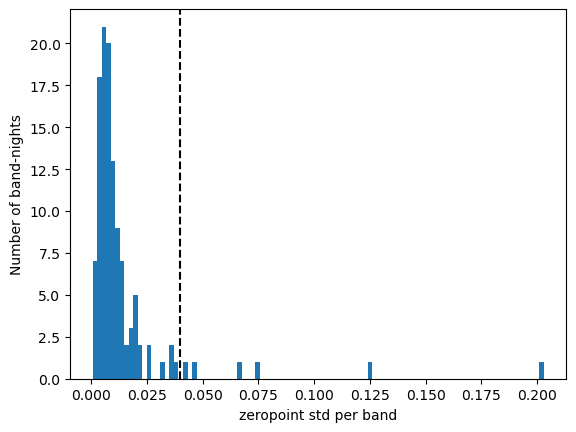

In [6]:
# Remove non-photometric nights by estimating the std of the zeropoint in each band
std = tab.groupby(['day_obs','band'])['zp_median'].std()
# Remove nights where the std in any band is >0.05 mag
std_thresh = 0.04
plt.hist(std, bins=100)
plt.axvline(std_thresh, ls='--', color='k')
plt.xlabel("zeropoint std per band")
plt.ylabel("Number of band-nights")

day_obs = std[std >= std_thresh].index.get_level_values('day_obs')
sel = ~tab['day_obs'].isin(day_obs)
tab = tab[sel].reset_index(drop=True)

print(f"Non-Photometric nights: {day_obs.values}")

We plot the zeropoint scale, which is calculated in [computeExposureSummaryStats](https://github.com/lsst/pipe_tasks/blob/fa151169a4523ce262c5767c4d8f8e9f79f26a50/python/lsst/pipe/tasks/computeExposureSummaryStats.py#L656-L658) as 

```
  zeroPointDiff = fiducialZeroPoint - (summary.zeroPoint - 2.5*np.log10(exposureTime))
  c_eff = min(10**(-2.0*(zeroPointDiff)/2.5), self.config.maxEffectiveTransparency)
```

The zeropoint scale can be seent to be consistently > 1.0, which would be interpreted as the transparency being better than perfect. Since observers commonly attempt to use this metric as a proxy of cloud extincition, this leads to a confusing situation of negative clouds...

Text(0.5, 0, 'exp_midpt_mjd')

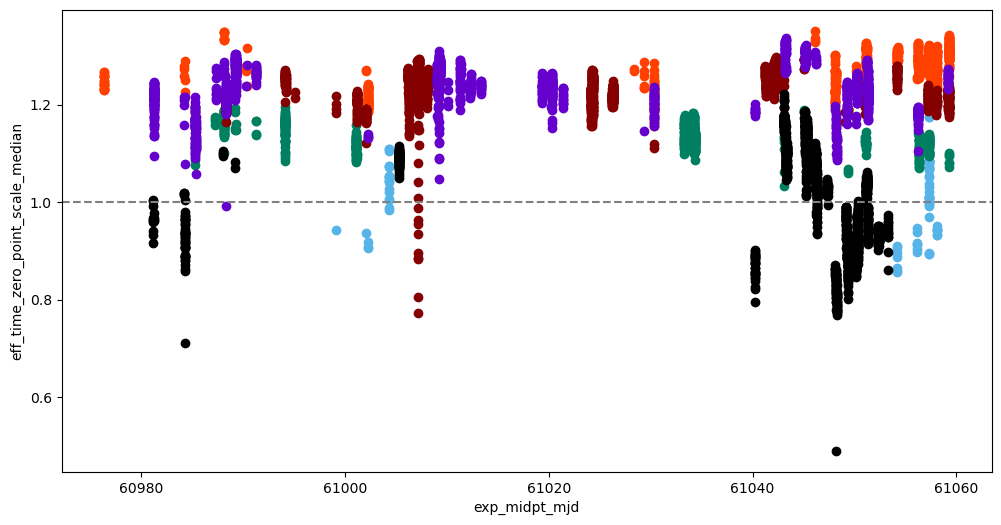

In [7]:
# Plot the Zeropoint scale
plt.figure(figsize=(12,6))
for band,color in BAND_COLORS.items():
    sel = tab['band'] == band
    plt.scatter(tab[sel]['exp_midpt_mjd'], tab[sel]['eff_time_zero_point_scale_median'], color=color)

plt.axhline(1.0, ls='--', color='gray')
plt.ylabel('eff_time_zero_point_scale_median')
plt.xlabel('exp_midpt_mjd')

This same offset can be seen in the unnormalized zeropoints, which we plot with their fiducial values (dashed lines).

Text(0.5, 0, 'exp_midpt_mjd')

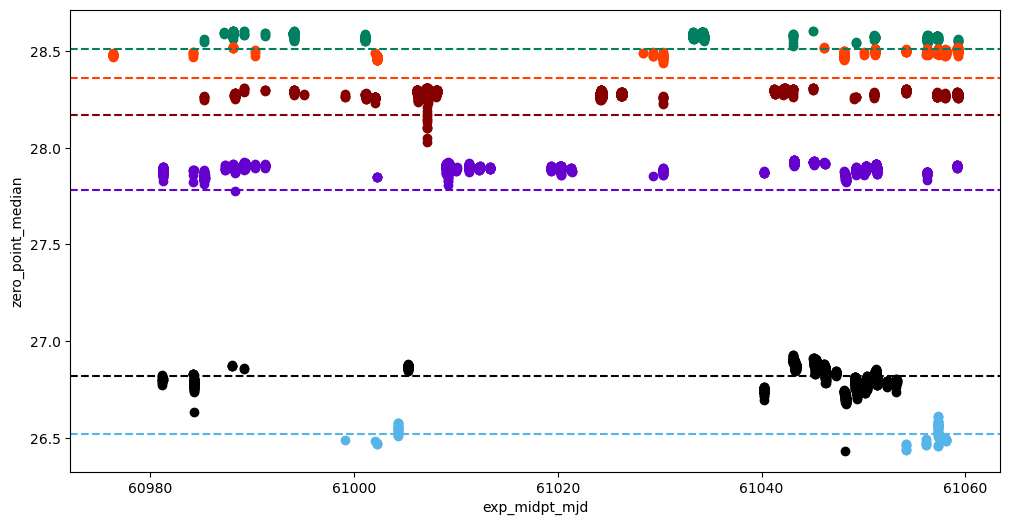

In [8]:
plt.figure(figsize=(12,6))
for band,color in BAND_COLORS.items():
    sel = tab['band'] == band
    plt.scatter(tab[sel]['exp_midpt_mjd'], tab[sel]['zp_median'], color=color)
    plt.axhline(fiducialZeroPoint[band], ls='--', color=color, label=band)

plt.ylabel('zero_point_median')
plt.xlabel('exp_midpt_mjd')

As a first-order correction, we can simply calculate the offset between the fiducial value of the zeropoint and the observed zeropoints. There is some debate about how to calculated the "observed" zeropoints (i.e., should we take the most common value of the zeropoint, or should we take the "deepest" zeropoint?), which boils down to where you think the scatter in the zeropoint values is coming from. We investigate various sources of scatter later in this notebook. For right now, we just choose to estimate the offset from the peak in the distributions.

u: 0.030
g: 0.065
r: 0.143
i: 0.124
z: 0.116
y: 0.049
{'u': 26.549781012208154, 'g': 28.57471558900695, 'r': 28.5027835321442, 'i': 28.29447636911208, 'z': 27.896199850865628, 'y': 26.86861071415715}


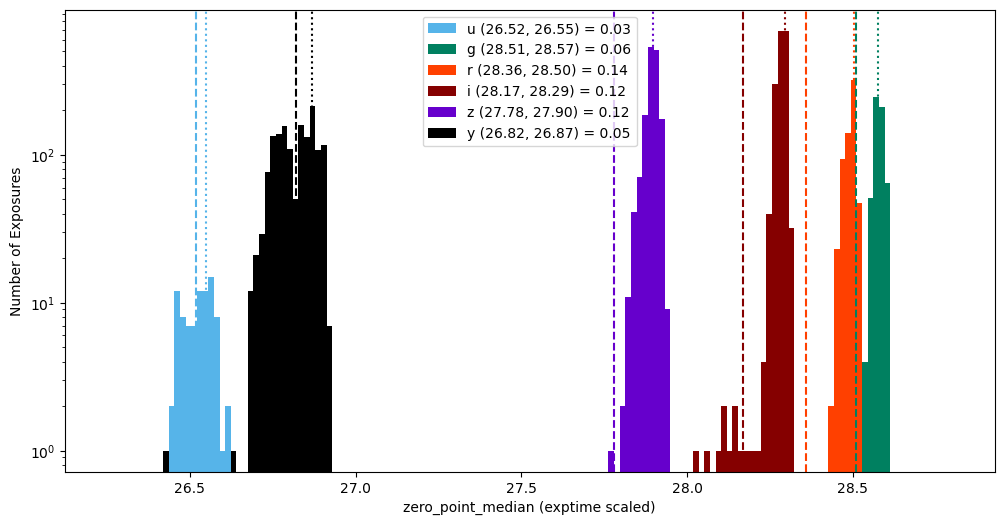

In [9]:
# Store the offset values
OFFSETS = dict()

# Some configurations
bins=np.linspace(26.25,28.8,151)
centers = (bins[1:]+bins[:-1])/2.
kw = dict(bins=bins, log=True)

plt.figure(figsize=(12,6))
for band,color in BAND_COLORS.items():
    sel = tab['band'] == band
    sel &= ~(tab['zero_point_median'] == None)
    
    zp = tab[sel]['zp_median']

    # Calculate some stats on the distribution
    median = np.median(zp)
    num, _ = np.histogram(zp, bins=bins)
    mode = centers[num.argmax()]
    peak = kde_peak(zp)
    stats = sigma_clipped_stats(zp)
    
    offset = float(peak - fiducialZeroPoint[band])
    label=f"{band} ({fiducialZeroPoint[band]:.2f}, {peak:.2f}) = {offset:.2f}"

    plt.hist(zp, color=color, label= label, **kw)

    plt.axvline(fiducialZeroPoint[band], ls='--', color=color)
    plt.axvline(peak, ls=':', color=color)

    OFFSETS[band] = offset

plt.legend()
plt.xlabel('zero_point_median (exptime scaled)')
plt.ylabel("Number of Exposures")

[print(f"{k}: {v:.3f}") for k,v in OFFSETS.items()]
new_fiducialZeroPoint = {k: v+OFFSETS[k] for k,v in fiducialZeroPoint.items()}
print(new_fiducialZeroPoint)

(0.5, 1.2)

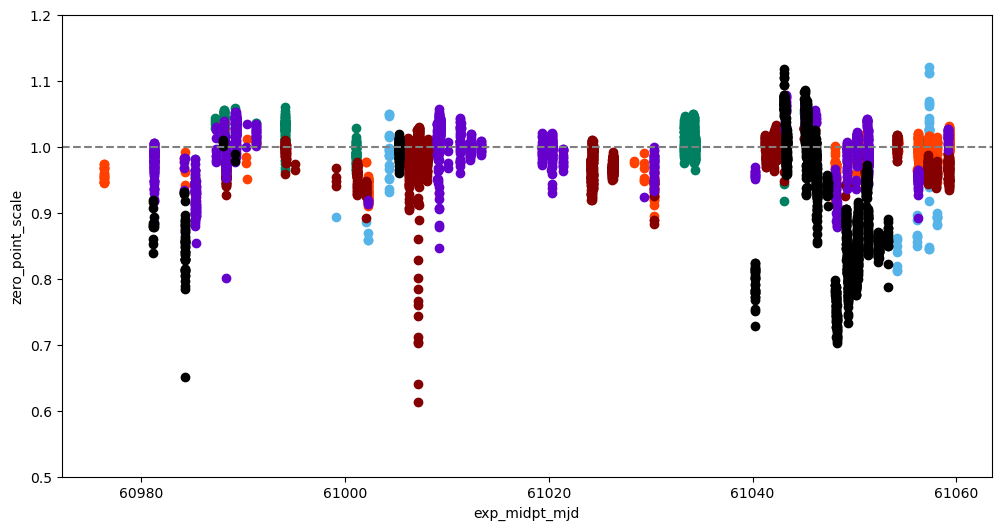

In [10]:
# Calucate the zeroPointScale with the new fiducial values
plt.figure(figsize=(12,6))
for band,color in BAND_COLORS.items():
    sel = tab['band'] == band
    
    zeroPoint = tab[sel]['zp_median']
    zeroPointDiff = new_fiducialZeroPoint[band] - zeroPoint
    zeroPointScale = 10**(-2.0*(zeroPointDiff)/2.5)
        
    plt.scatter(tab[sel]['exp_midpt_mjd'], zeroPointScale, color=color)

plt.axhline(1.0, ls='--', color='gray')
plt.ylabel('zero_point_scale')
plt.xlabel('exp_midpt_mjd')
plt.ylim(0.5,1.2)

In [11]:
print('# Old Fiducial ZeroPoint in electrons for 1s exposure')
print('fiducialZeroPoint = {')
for k,v in fiducialZeroPoint.items():
    print(f'  "{k}": {v:.2f},')
print('}')
print()
print('# New Fiducial ZeroPoint in electrons for 1s exposure')
print('# Offsets calculated from commissioning data (DM-53728)')
print('fiducialZeroPoint = {')
for k,v in fiducialZeroPoint.items():
    print(f'  "{k}": {v:.2f} + {OFFSETS[k]:.2f},')
print('}')
print()
print('# New Fiducial ZeroPoint in electrons for 1s exposure')
print('# Calculated from commissioning data (DM-53728)')
print('fiducialZeroPoint = {')
for k,v in new_fiducialZeroPoint.items():
    print(f'  "{k}": {v:.2f},')
print('}')

# Old Fiducial ZeroPoint in electrons for 1s exposure
fiducialZeroPoint = {
  "u": 26.52,
  "g": 28.51,
  "r": 28.36,
  "i": 28.17,
  "z": 27.78,
  "y": 26.82,
}

# New Fiducial ZeroPoint in electrons for 1s exposure
# Offsets calculated from commissioning data (DM-53728)
fiducialZeroPoint = {
  "u": 26.52 + 0.03,
  "g": 28.51 + 0.06,
  "r": 28.36 + 0.14,
  "i": 28.17 + 0.12,
  "z": 27.78 + 0.12,
  "y": 26.82 + 0.05,
}

# New Fiducial ZeroPoint in electrons for 1s exposure
# Calculated from commissioning data (DM-53728)
fiducialZeroPoint = {
  "u": 26.55,
  "g": 28.57,
  "r": 28.50,
  "i": 28.29,
  "z": 27.90,
  "y": 26.87,
}


## Scatter in Zeropoints

During the course of this investigation, there was some speculation over what was leading to the spread in zeropoint values around the peak. In theory, you would have a pretty stable maximum zeropoint that would occur during photometric nights. However, we see consistently across bands a peak with some scatter about that peak. It may be that this scatter is statistical (i.e., coming from the zeropoint fitting procedure), or it may come from real physical variations in the atmospheric throughput night to night, or even within a night. Such variation could be attributed to the perceptible water vapor. We explore the statistical scatter a little below.

In [12]:
from lsst.summit.utils import ConsDbClient
from lsst.summit.utils.utils import computeCcdExposureId
os.environ["no_proxy"] += ",.consdb"

client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')

query = f"""
select v.visit_id, c2v.detector, v.band, v.day_obs, v.exp_midpt_mjd, v.exp_time, v.airmass, 
q.psf_sigma, q.zero_point, q.eff_time_zero_point_scale
from cdb_lsstcam.ccdvisit1_quicklook q, cdb_lsstcam.ccdvisit1 c2v, cdb_lsstcam.visit1 v
where 
q.ccdvisit_id = c2v.ccdvisit_id
and c2v.visit_id = v.visit_id
and v.day_obs between {DAY_OBS_MIN} and {DAY_OBS_MAX}
and v.day_obs not in {DAY_OBS_BAD}
and v.img_type = 'science'
and v.science_program in ('BLOCK-407', 'BLOCK-408', 'BLOCK-416', 'BLOCK-417', 'BLOCK-419', 'BLOCK-421')
and q.zero_point is not Null
and v.airmass < 1.1
and q.psf_sigma*0.2*2.355 < 1.5
order by v.visit_id"""
df = client.query(query).to_pandas()
df['zp'] = df['zero_point'] - 2.5*np.log10(df['exp_time'])
df

,visit_id,detector,band,day_obs,exp_midpt_mjd,exp_time,airmass,psf_sigma,zero_point,eff_time_zero_point_scale,zp
0,2025102400105,188,z,20251024,60973.062258,30.0,1.048508,2.886094,31.559856,1.173926,27.867053
1,2025102400105,181,z,20251024,60973.062258,30.0,1.048508,2.904218,31.556139,1.165912,27.863336
2,2025102400105,180,z,20251024,60973.062258,30.0,1.048508,2.882648,31.559307,1.172738,27.866504
3,2025102400105,179,z,20251024,60973.062258,30.0,1.048508,2.855577,31.560425,1.175152,27.867622
4,2025102400105,178,z,20251024,60973.062258,30.0,1.048508,2.867685,31.566860,1.189167,27.874057
...,...,...,...,...,...,...,...,...,...,...,...
669941,2026011800386,184,r,20260118,61059.289513,30.0,1.098990,2.511456,32.186208,1.278480,28.493405
669942,2026011800386,185,r,20260118,61059.289513,30.0,1.098990,2.614855,32.185571,1.276983,28.492768
669943,2026011800386,186,r,20260118,61059.289513,30.0,1.098990,2.535420,32.191340,1.290625,28.498537
669944,2026011800386,187,r,20260118,61059.289513,30.0,1.098990,2.619492,32.204524,1.322353,28.511721


Text(0.5, 0, 'exp_midpt_mjd')

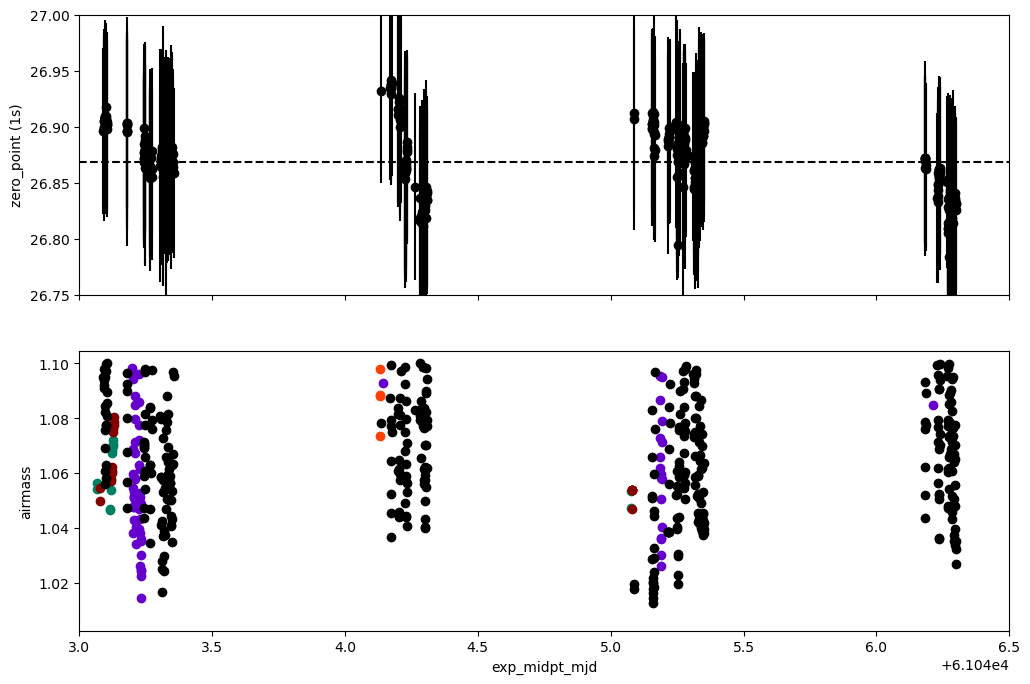

In [13]:
# Investigate photometric nights
# Estimate the scatter in zeropoints across detectors in a visit

fig, axes = plt.subplots(2,1, figsize=(12,8), sharex=True)
for band,color in BAND_COLORS.items():
    sel = df['band'] == band
    grp = df[sel].groupby('visit_id')
    exp_midpt_mjd = grp['exp_midpt_mjd'].mean()
    airmass = grp['airmass'].mean()
    zp_median = grp['zp'].median()
    zp_std = grp['zp'].std()
    plt.sca(axes.flat[0])
    plt.errorbar(exp_midpt_mjd, zp_median, yerr=zp_std, color=color, marker='o', ls='')
    plt.axhline(new_fiducialZeroPoint[band], ls='--', color=color, label=band)

    plt.sca(axes.flat[1])
    plt.plot(exp_midpt_mjd, airmass, marker='o', ls='', color=color)
    
# Several weeks of g,r,i
if True:
    axes[0].set_ylim(28.2,28.65)
    axes[1].set_xlim(60983,61003)

# One sequence of r-band
if False:
    axes[0].set_ylim(28.42,28.5)
    axes[1].set_xlim(60996.25,60996.35) 

# One sequence of y-band
if True:
    axes[0].set_ylim(26.75,27.0)
    axes[1].set_xlim(61043,61046.5) 

axes[0].set_ylabel('zero_point (1s)')
axes[1].set_ylabel('airmass')
plt.xlabel('exp_midpt_mjd')

Text(0, 0.5, 'Number of Exposures')

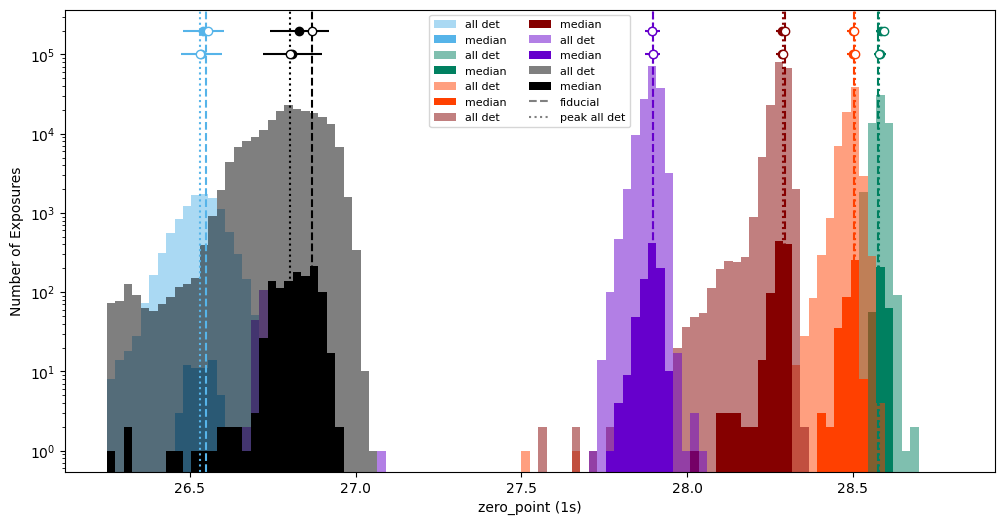

In [14]:
# Plot the distribution of zeropoints for each detector 
# in each visit rather than the median.

bins=np.linspace(26.25,28.8,101)
centers = (bins[1:]+bins[:-1])/2.
kw = dict(bins=bins, log=True)

plt.figure(figsize=(12,6))
for band,color in BAND_COLORS.items():
    sel = df['band'] == band
    sel &= ~(df['zero_point'] == None)
    zp = df[sel]['zp']
    zp94 = df[sel & (df['detector'] == 94)]['zp'] # e2V
    zp172 = df[sel & (df['detector'] == 172)]['zp'] # ITL

    grp = df[sel].groupby('visit_id')

    # Stats across all detectors and visits
    zp_stats = sigma_clipped_stats(zp)
    zp_peak = kde_peak(zp)
    
    # Stats grouped by visit
    median_zp = grp['zp'].median()
    median_zp_stats = sigma_clipped_stats(median_zp)
    median_zp_peak = kde_peak(median_zp)

    label=f"{band} ({new_fiducialZeroPoint[band]:.2f}, {zp_peak:.2f})"

    plt.hist(zp, color=color, alpha=0.5, label='all det', **kw)
    #plt.hist(zp94, color=color,  alpha=0.5, label='det94', **kw)
    #plt.hist(zp172, color=color,  alpha=0.5, label='det172', **kw)
    plt.hist(median_zp, color=color, label='median', **kw)

    # Error bars
    yvalue = 1e5
    plt.errorbar(zp_stats[1], yvalue, xerr=zp_stats[-1], color=color, ls='', marker='o')
    plt.plot(zp_peak, yvalue, marker='o', mfc='w', color=color, zorder=10)

    plt.errorbar(median_zp_stats[1], 2*yvalue, xerr=zp_stats[-1], color=color, ls='', marker='o')
    plt.plot(median_zp_peak, 2*yvalue, marker='o', mfc='w', color=color, zorder=10)

    plt.axvline(new_fiducialZeroPoint[band], ls='--', color=color)
    plt.axvline(zp_peak, ls=':', color=color)

plt.plot(np.nan, np.nan, ls='--', color='gray', label='fiducial')
plt.plot(np.nan, np.nan, ls=':', color='gray', label='peak all det')

plt.legend(ncols=2, fontsize=8, loc='upper center')
plt.xlabel('zero_point (1s)')
plt.ylabel("Number of Exposures")

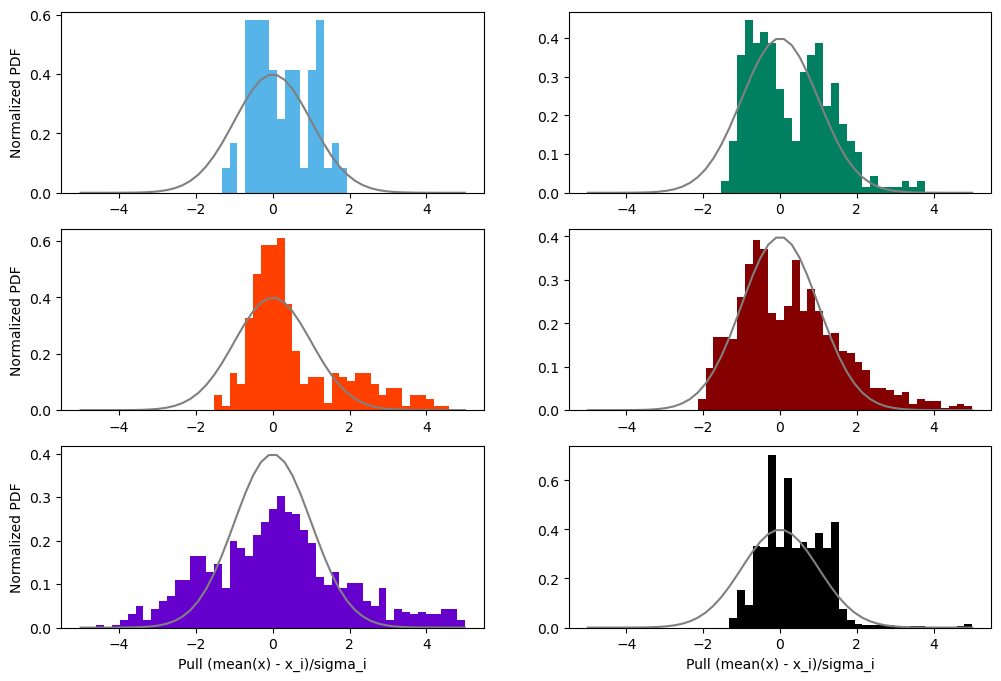

In [15]:
# Pull distribution using error estimated from spread of detectors within exposure
# If the visit-to-visit scatter in the median zeropoint is well described by the scatter 
# in detector zeropoints across the exposure, then the resulting pull distribution should 
# be the standard normal distribution.

fig, axes = plt.subplots(3,2, figsize=(12,8))
for i,(band,color) in enumerate(BAND_COLORS.items()):
    plt.sca(axes.flat[i])

    sel = df['band'] == band
    sel &= ~(df['zero_point'] == None)
    grp = df[sel].groupby('visit_id')
    
    zp_mean = grp['zp'].mean()
    zp_median = grp['zp'].median()
    zp_std = grp['zp'].std()

    mean = np.mean(zp_mean)
    median = np.median(zp_median)
   
    zp_fid = new_fiducialZeroPoint[band]

    pull = (median - zp_mean)/zp_std
    bins = np.linspace(-5,5)
    plt.hist(pull, bins=bins, color=color, density=True)

    plt.plot(bins,scipy.stats.norm.pdf(bins),color='gray')
    if i in (0, 2, 4):
        plt.ylabel('Normalized PDF')
    if i in (4, 5):
        plt.xlabel('Pull (mean(x) - x_i)/sigma_i')

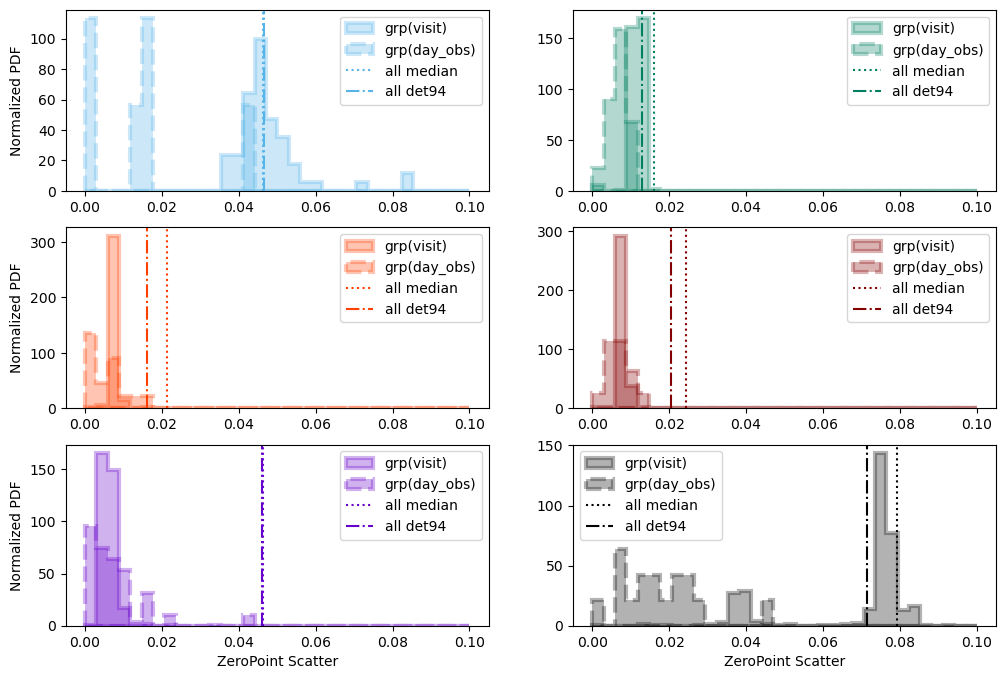

In [16]:
# Compare various estimates of the scatter
bins=np.linspace(0,0.1,35)
centers = (bins[1:]+bins[:-1])/2.
kw = dict(bins=bins, alpha=0.3, lw=3, histtype='stepfilled', density=True)

fig, axes = plt.subplots(3,2, figsize=(12,8))
for i,(band,color) in enumerate(BAND_COLORS.items()):
    plt.sca(axes.flat[i])
    
    sel = df['band'] == band
    sel &= ~(df['zero_point'] == None)

    visit_grp = df[sel].groupby('visit_id')
    day_grp = df[sel & (df['detector'] == 94)].groupby('day_obs')
    zp94 = df[sel & (df['detector'] == 94)]['zp']
    
    visit_stats = visit_grp['zp'].apply(apply_sigma_clipped_stats).unstack()
    day_stats = day_grp['zp'].apply(apply_sigma_clipped_stats).unstack()

    # Scatter of detector zeropoints within each exposure
    plt.hist(visit_stats['std'], color=color, ec=color, ls='-', label='grp(visit)', **kw)
    # Scatter in one detector across each night 
    plt.hist(day_stats['std'], color=color, ec=color, ls='--', label='grp(day_obs)', **kw)
    # Scatter in the median zeropoint of each visit across all visits on all nights
    plt.axvline(np.std(visit_stats['median']), color=color, ls=':', label='all median')
    # Scatter in the zeropoint of det=94 across all visits on all nights
    plt.axvline(np.std(zp94), color=color, ls='-.', label='all det94')
    
    plt.legend()    

    if i in (0, 2, 4):
        plt.ylabel('Normalized PDF')
    if i in (4, 5):
        plt.xlabel('ZeroPoint Scatter')

While this is not very rigorous, the conclusion that I draw is that the scatter of the zeropoints between detectors on the same visit is roughly comparable in magnitude to the scatter in the median zeropoint across visits. Furthermore, in all bands except u, the visit-to-visit scatter in the median zeropoint is larger than the visit-to-visit scatter in the zeropoint of a single detector (suggesting that the median process is not reducing the scatter).

For these reasons, I think choosing the peak of the zeropoint distribution is likely more robust than taking one (or a few) zeropoints on the upper tail of the distribution.